In [35]:
import os
from sklearn.model_selection import train_test_split
import cv2  
import numpy as np
import matplotlib.pyplot as plt

In [36]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


def convert_to_gray(img):
    gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    return gray_img

def convert_to_lab(img):
    lab_img = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    return lab_img

def extract_a_channel(lab_img):
    a_channel = lab_img[:, :, 1]

    return a_channel

def apply_clahe(a_channel):
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    equalized_a_channel = clahe.apply(a_channel)
    return equalized_a_channel

def dilate_image(img):
    kernel = np.ones((3, 3), np.uint8)
    dilated_img = cv2.dilate(img, kernel, iterations=1)

    return dilated_img

def apply_threshold(img):
    _, thresholded_img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    return thresholded_img

def preprocess_image(img):
    gray_img = convert_to_gray(img)
    lab_img = convert_to_lab(img)
    a_channel = extract_a_channel(lab_img)
    equalized_a_channel = apply_clahe(a_channel)
    dilated_img = dilate_image(equalized_a_channel)
    thresholded_img = apply_threshold(dilated_img)
    thresholded_img = np.expand_dims(thresholded_img, axis=-1)
    color_img = np.repeat(thresholded_img, 3, axis=-1)
    return color_img




In [37]:
def load_images_from_folder(folder, target_size=(256, 256), test_size=0.3):
    images = []
    labels = []

    for label, class_folder in enumerate(os.listdir(folder)):
        class_path = os.path.join(folder, class_folder)
        for filename in os.listdir(class_path):
            img_path = os.path.join(class_path, filename)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, target_size)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                preprocessed_img = preprocess_image(img)
                images.append(preprocessed_img)
                labels.append(label)

    X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=test_size, random_state=42)

    return X_train, X_test, y_train, y_test

In [38]:
folder_path = 'C:\SUDHARSHAN\miniProject\Dataset'
X_train, X_test, y_train, y_test = load_images_from_folder(folder_path)



In [39]:
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (1260, 256, 256, 3)
X_test shape: (540, 256, 256, 3)
y_train shape: (1260,)
y_test shape: (540,)


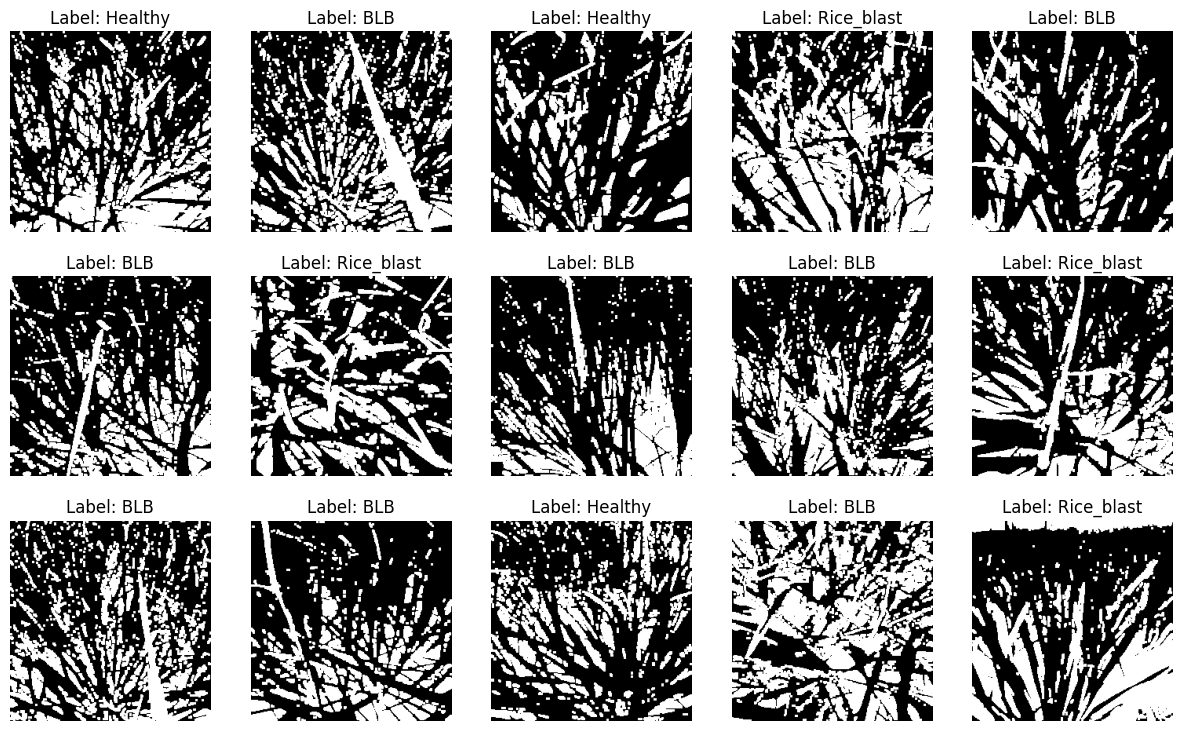

In [40]:
import matplotlib.pyplot as plt

mappings={0:"Healthy",1:"Rice_blast",2:"BLB"}
def visualize_images(images, labels):
    fig, axes = plt.subplots(3, 5, figsize=(15, 9))
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i],cmap = "summer")
        ax.set_title(f"Label: {mappings[labels[i]]}")
        ax.axis('off')
    plt.show()

visualize_images(X_train[15:30], y_train[15:30])


In [41]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import Dropout, Flatten, Input, Dense
import tensorflow as tf

def create_model():
    
    def add_conv_block(model, num_filters):
        
        model.add(Conv2D(num_filters, 3, activation='relu', padding='same'))
        model.add(BatchNormalization())
        model.add(Conv2D(num_filters, 3, activation='relu', padding='valid'))
        model.add(MaxPooling2D(pool_size=2))
        model.add(Dropout(0.2))

        return model
    
    model = tf.keras.models.Sequential()
    model.add(Input(shape=(256, 256,3)))
    
    model = add_conv_block(model, 32)
    model = add_conv_block(model, 64)
    model = add_conv_block(model, 128)
    model = add_conv_block(model, 256)

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(3, activation='softmax'))

    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

model = create_model()
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 256, 256, 32)      896       
                                                                 
 batch_normalization_8 (Bat  (None, 256, 256, 32)      128       
 chNormalization)                                                
                                                                 
 conv2d_17 (Conv2D)          (None, 254, 254, 32)      9248      
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 127, 127, 32)      0         
 g2D)                                                            
                                                                 
 dropout_12 (Dropout)        (None, 127, 127, 32)      0         
                                                                 
 conv2d_18 (Conv2D)          (None, 127, 127, 64)     

In [42]:
%%time

rice_bios_model = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100, batch_size=128
    )

Epoch 1/100
10/10 [==============================] - 185s 18s/step - loss: 20.4460 - accuracy: 0.3571 - val_loss: 3.8105 - val_accuracy: 0.3407
Epoch 2/100
10/10 [==============================] - 184s 18s/step - loss: 2.1382 - accuracy: 0.3635 - val_loss: 7.4045 - val_accuracy: 0.3111
Epoch 3/100
10/10 [==============================] - 184s 19s/step - loss: 1.0728 - accuracy: 0.4095 - val_loss: 7.5284 - val_accuracy: 0.3111
Epoch 4/100
10/10 [==============================] - 185s 19s/step - loss: 1.0105 - accuracy: 0.4952 - val_loss: 14.5338 - val_accuracy: 0.3111
Epoch 5/100
10/10 [==============================] - 187s 19s/step - loss: 0.9213 - accuracy: 0.5778 - val_loss: 8.0843 - val_accuracy: 0.3111
Epoch 6/100
10/10 [==============================] - 185s 19s/step - loss: 0.8841 - accuracy: 0.5952 - val_loss: 11.1095 - val_accuracy: 0.3111
Epoch 7/100
10/10 [==============================] - 196s 20s/step - loss: 0.8275 - accuracy: 0.6389 - val_loss: 4.9357 - val_accuracy: 0.3

In [43]:
training_accuracy = rice_bios_model.history['accuracy'][-1]
validation_accuracy = rice_bios_model.history['val_accuracy'][-1]

print("Training Accuracy:", training_accuracy)
print("Validation Accuracy:", validation_accuracy)

Training Accuracy: 0.9888888597488403
Validation Accuracy: 0.8055555820465088


In [44]:
model.save('RB_Model_70_30.h5')

C:\Users\sudha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [48]:
from tensorflow.keras.models import load_model

# Load the model
model = load_model('RB_Model_80_20.h5')


In [49]:
import numpy as np
from sklearn.metrics import accuracy_score

# Assuming X_test and y_test are your test data
# X_test = ...
# y_test = ...

# Normalize X_test if needed
# X_test = normalize_data(X_test)

# Make predictions on the test data
y_pred = model.predict(X_test)
# Convert the probabilities to class labels
y_pred_labels = np.argmax(y_pred, axis=1)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred_labels)
print("Accuracy:", accuracy)


17/17 [==============================] - 9s 529ms/step
Accuracy: 0.937037037037037


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)